In [263]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Datavis import *

data = np.load('datasets/MC_data_5_14.npy')
print(data.shape)
# head of data
print(data[0:5])

(10000, 75)
[[0 0 0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0
  0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1
  0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0
  0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0
  0 0 0]
 [1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1
  0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 0 0]
 [0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]]


In [264]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [265]:
def genModel():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(25, activation='tanh'),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.Dense(100, activation='tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(50, activation='sigmoid')])
    return model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [266]:
scores_bce_ba = {}
scores_bce_f1 = {}
scores_f1_ba = {}
scores_f1_f1 = {}

for rate in [14, 15, 16, 17, 18]:

    data = np.load(f'datasets/MC_data_5_{rate}.npy')
    syndrome = data[:, :25]
    errors = data[:, 25:]

    train_data = syndrome[0:8000]
    train_labels = errors[0:8000]
    test_data = syndrome[8000:]
    test_labels = errors[8000:]
    
    
    model_f1 = genModel()
    model_f1 = genModel()

    model_f1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', macro_f1])
    model_f1.compile(optimizer='adam', loss=macro_soft_f1, metrics=['binary_accuracy', macro_f1])

    history_bce = model_f1.fit(train_data, train_labels, 
                    epochs=100, 
                    batch_size=1024,
                    validation_split=0.2,
                    callbacks=[early_stopping])

    history_f1 = model_f1.fit(train_data, train_labels,
                    epochs=100,
                    batch_size=1024,
                    validation_split=0.2,
                    callbacks=[early_stopping])
    
    model_f1.save(f'models/MC_bce_5_{rate}.h5')
    model_f1.save(f'models/MC_f1_5_{rate}.h5')

    # store best binary accuracy score for model_bce
    scores_bce_ba[rate] = max(history_bce.history['val_binary_accuracy'])
    scores_bce_f1[rate] = max(history_bce.history['val_macro_f1'])
    scores_f1_ba[rate] = max(history_f1.history['val_binary_accuracy'])
    scores_f1_f1[rate] = max(history_f1.history['val_macro_f1'])

    





Epoch 1/100


2023-08-28 20:33:12.636233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.7480 - binary_accuracy: 0.5333 - macro_f1: 0.2747

2023-08-28 20:33:26.219941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 18s 2s/step - loss: 0.7480 - binary_accuracy: 0.5333 - macro_f1: 0.2747 - val_loss: 0.7675 - val_binary_accuracy: 0.4231 - val_macro_f1: 0.2773
Epoch 2/100
7/7 [==============================] - 4s 600ms/step - loss: 0.7175 - binary_accuracy: 0.5613 - macro_f1: 0.3129 - val_loss: 0.7594 - val_binary_accuracy: 0.4034 - val_macro_f1: 0.2852
Epoch 3/100
7/7 [==============================] - 1s 128ms/step - loss: 0.7045 - binary_accuracy: 0.5734 - macro_f1: 0.3296 - val_loss: 0.7534 - val_binary_accuracy: 0.3902 - val_macro_f1: 0.2890
Epoch 4/100
7/7 [==============================] - 0s 67ms/step - loss: 0.6948 - binary_accuracy: 0.5808 - macro_f1: 0.3374 - val_loss: 0.7481 - val_binary_accuracy: 0.4071 - val_macro_f1: 0.2962
Epoch 5/100
7/7 [==============================] - 1s 110ms/step - loss: 0.6871 - binary_accuracy: 0.5887 - macro_f1: 0.3454 - val_loss: 0.7436 - val_binary_accuracy: 0.4237 - val_macro_f1: 0.3035
Epoch 6/100
7/7 [=============

2023-08-28 20:34:07.858933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.7374 - binary_accuracy: 0.5320 - macro_f1: 0.2859

2023-08-28 20:34:22.406394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 19s 2s/step - loss: 0.7374 - binary_accuracy: 0.5320 - macro_f1: 0.2859 - val_loss: 0.7557 - val_binary_accuracy: 0.4239 - val_macro_f1: 0.2852
Epoch 2/100
7/7 [==============================] - 4s 652ms/step - loss: 0.7083 - binary_accuracy: 0.5580 - macro_f1: 0.3216 - val_loss: 0.7479 - val_binary_accuracy: 0.4128 - val_macro_f1: 0.2906
Epoch 3/100
7/7 [==============================] - 2s 252ms/step - loss: 0.6958 - binary_accuracy: 0.5685 - macro_f1: 0.3355 - val_loss: 0.7418 - val_binary_accuracy: 0.4005 - val_macro_f1: 0.2993
Epoch 4/100
7/7 [==============================] - 1s 119ms/step - loss: 0.6870 - binary_accuracy: 0.5752 - macro_f1: 0.3446 - val_loss: 0.7370 - val_binary_accuracy: 0.3870 - val_macro_f1: 0.3010
Epoch 5/100
7/7 [==============================] - 2s 335ms/step - loss: 0.6796 - binary_accuracy: 0.5812 - macro_f1: 0.3522 - val_loss: 0.7328 - val_binary_accuracy: 0.3898 - val_macro_f1: 0.3050
Epoch 6/100
7/7 [============

2023-08-28 20:35:03.134504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.7280 - binary_accuracy: 0.5307 - macro_f1: 0.2947

2023-08-28 20:35:14.973805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 16s 2s/step - loss: 0.7280 - binary_accuracy: 0.5307 - macro_f1: 0.2947 - val_loss: 0.7442 - val_binary_accuracy: 0.4167 - val_macro_f1: 0.2941
Epoch 2/100
7/7 [==============================] - 3s 298ms/step - loss: 0.6997 - binary_accuracy: 0.5550 - macro_f1: 0.3293 - val_loss: 0.7365 - val_binary_accuracy: 0.3958 - val_macro_f1: 0.3013
Epoch 3/100
7/7 [==============================] - 1s 179ms/step - loss: 0.6882 - binary_accuracy: 0.5637 - macro_f1: 0.3420 - val_loss: 0.7304 - val_binary_accuracy: 0.3871 - val_macro_f1: 0.3060
Epoch 4/100
7/7 [==============================] - 2s 268ms/step - loss: 0.6796 - binary_accuracy: 0.5695 - macro_f1: 0.3494 - val_loss: 0.7254 - val_binary_accuracy: 0.3965 - val_macro_f1: 0.3123
Epoch 5/100
7/7 [==============================] - 1s 107ms/step - loss: 0.6723 - binary_accuracy: 0.5750 - macro_f1: 0.3568 - val_loss: 0.7219 - val_binary_accuracy: 0.3606 - val_macro_f1: 0.3097
Epoch 6/100
7/7 [============

2023-08-28 20:35:50.121438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.7186 - binary_accuracy: 0.5293 - macro_f1: 0.3023

2023-08-28 20:36:03.444899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 17s 2s/step - loss: 0.7186 - binary_accuracy: 0.5293 - macro_f1: 0.3023 - val_loss: 0.7342 - val_binary_accuracy: 0.4434 - val_macro_f1: 0.3050
Epoch 2/100
7/7 [==============================] - 3s 527ms/step - loss: 0.6925 - binary_accuracy: 0.5530 - macro_f1: 0.3344 - val_loss: 0.7266 - val_binary_accuracy: 0.4124 - val_macro_f1: 0.3064
Epoch 3/100
7/7 [==============================] - 1s 167ms/step - loss: 0.6807 - binary_accuracy: 0.5617 - macro_f1: 0.3476 - val_loss: 0.7209 - val_binary_accuracy: 0.4035 - val_macro_f1: 0.3162
Epoch 4/100
7/7 [==============================] - 2s 242ms/step - loss: 0.6731 - binary_accuracy: 0.5653 - macro_f1: 0.3553 - val_loss: 0.7152 - val_binary_accuracy: 0.3988 - val_macro_f1: 0.3240
Epoch 5/100
7/7 [==============================] - 4s 404ms/step - loss: 0.6663 - binary_accuracy: 0.5692 - macro_f1: 0.3626 - val_loss: 0.7119 - val_binary_accuracy: 0.3884 - val_macro_f1: 0.3256
Epoch 6/100
7/7 [============

2023-08-28 20:36:39.103795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.7105 - binary_accuracy: 0.5271 - macro_f1: 0.3080

2023-08-28 20:36:54.343322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 19s 2s/step - loss: 0.7105 - binary_accuracy: 0.5271 - macro_f1: 0.3080 - val_loss: 0.7228 - val_binary_accuracy: 0.4348 - val_macro_f1: 0.3162
Epoch 2/100
7/7 [==============================] - 1s 174ms/step - loss: 0.6847 - binary_accuracy: 0.5496 - macro_f1: 0.3410 - val_loss: 0.7155 - val_binary_accuracy: 0.4190 - val_macro_f1: 0.3242
Epoch 3/100
7/7 [==============================] - 3s 431ms/step - loss: 0.6736 - binary_accuracy: 0.5575 - macro_f1: 0.3547 - val_loss: 0.7098 - val_binary_accuracy: 0.3745 - val_macro_f1: 0.3246
Epoch 4/100
7/7 [==============================] - 1s 238ms/step - loss: 0.6656 - binary_accuracy: 0.5620 - macro_f1: 0.3617 - val_loss: 0.7050 - val_binary_accuracy: 0.3693 - val_macro_f1: 0.3290
Epoch 5/100
7/7 [==============================] - 1s 105ms/step - loss: 0.6592 - binary_accuracy: 0.5651 - macro_f1: 0.3670 - val_loss: 0.7012 - val_binary_accuracy: 0.3543 - val_macro_f1: 0.3304
Epoch 6/100
7/7 [============

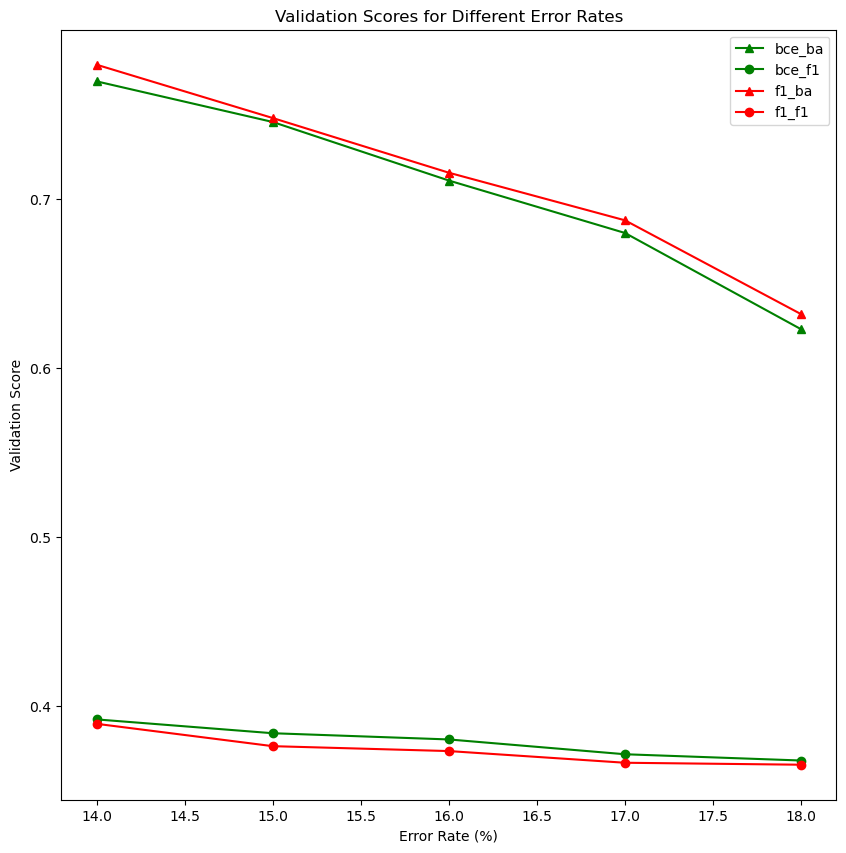

In [267]:
# plot the scores


plt.figure(figsize=(10, 10))
plt.plot(list(scores_bce_ba.keys()), list(scores_bce_ba.values()), 'g^-', label='bce_ba')
plt.plot(list(scores_bce_f1.keys()), list(scores_bce_f1.values()), 'go-', label='bce_f1')
plt.plot(list(scores_f1_ba.keys()), list(scores_f1_ba.values()), 'r^-', label='f1_ba')
plt.plot(list(scores_f1_f1.keys()), list(scores_f1_f1.values()), 'ro-', label='f1_f1')
plt.xlabel('Error Rate (%)')
plt.ylabel('Validation Score')
plt.title('Validation Scores for Different Error Rates')
plt.legend()
plt.show()

# make x axis integers


In [268]:
def avg_bin_acc(labels, pred):
    pred = tf.cast(tf.greater(pred, 0.5), tf.float32)
    return tf.reduce_mean(tf.cast(tf.equal(labels, pred), tf.float32))

In [269]:
eval_ba = {}
eval_f1 = {}

for rate in [14, 15, 16, 17, 18]:
    model_f1 = tf.keras.models.load_model(f'models/MC_f1_5_{rate}.h5', custom_objects={'macro_soft_f1': macro_soft_f1, 'macro_f1': macro_f1})
    data = np.load(f'datasets/MC_data_5_{rate}.npy')
    syndrome = data[:, :25]
    errors = data[:, 25:]
    test_data = syndrome[8000:]
    test_labels = errors[8000:]
    # make test_labels into float for macro_f1
    y = tf.cast(test_labels, tf.float32)
    yhat = model_f1.predict(test_data)

    print(y)

    binary_accuracy = avg_bin_acc(y, yhat)
    print(f'rate: {rate}')
    print(f'binary_accuracy: {binary_accuracy}')

    print(f'bce_f1: {macro_f1(y, yhat)}')
    print('\n')

    eval_ba[rate] = binary_accuracy
    eval_f1[rate] = macro_f1(y, yhat)

2023-08-28 20:37:30.747717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 3s 28ms/step
tf.Tensor(
[[0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]], shape=(2000, 50), dtype=float32)
rate: 14
binary_accuracy: 0.7760899662971497


2023-08-28 20:37:33.876658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


bce_f1: 0.38871756196022034




2023-08-28 20:37:34.778885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 3s 29ms/step
tf.Tensor(
[[0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]], shape=(2000, 50), dtype=float32)
rate: 15
binary_accuracy: 0.7448999881744385
bce_f1: 0.38256293535232544




2023-08-28 20:37:38.183317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 3s 27ms/step
tf.Tensor(
[[0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]], shape=(2000, 50), dtype=float32)
rate: 16
binary_accuracy: 0.6917200088500977
bce_f1: 0.3703012764453888




2023-08-28 20:37:41.388549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 3s 28ms/step
tf.Tensor(
[[0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]], shape=(2000, 50), dtype=float32)
rate: 17
binary_accuracy: 0.6796000003814697
bce_f1: 0.3694819509983063




2023-08-28 20:37:44.811525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 21ms/step
tf.Tensor(
[[1. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]], shape=(2000, 50), dtype=float32)
rate: 18
binary_accuracy: 0.6072700023651123
bce_f1: 0.36788856983184814




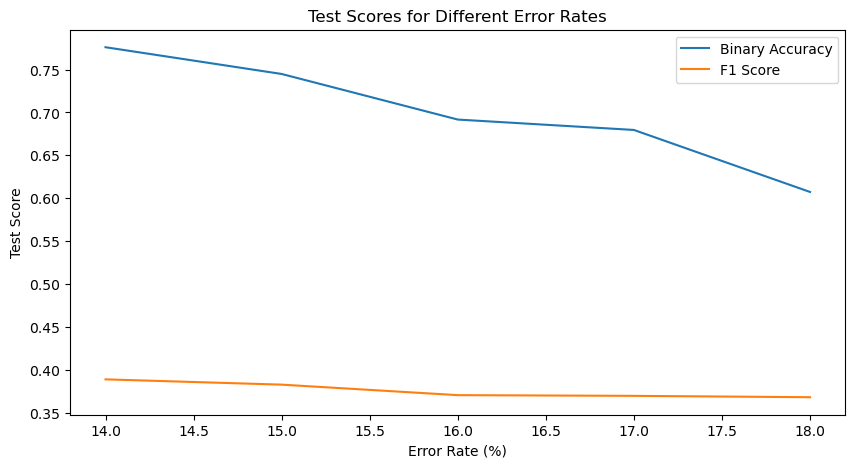

In [270]:
# plot eval scores

plt.figure(figsize=(10, 5))
plt.plot(list(eval_ba.keys()), list(eval_ba.values()), '-', label='Binary Accuracy')
plt.plot(list(eval_f1.keys()), list(eval_f1.values()), '-', label='F1 Score')
plt.xlabel('Error Rate (%)')
plt.ylabel('Test Score')
plt.title('Test Scores for Different Error Rates')
plt.legend()
plt.show()

In [271]:
model = tf.keras.models.load_model('models/MC_f1_5_18.h5', custom_objects={'macro_soft_f1': macro_soft_f1}, compile=False)
data = np.load('datasets/MC_data_5_14.npy')
syndrome = data[:, :25]
errors = data[:, 25:]
test_data = syndrome[8000:]
test_labels = errors[8000:]
pred = model.predict(test_data)



2023-08-28 20:37:47.223814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 3s 26ms/step


1011


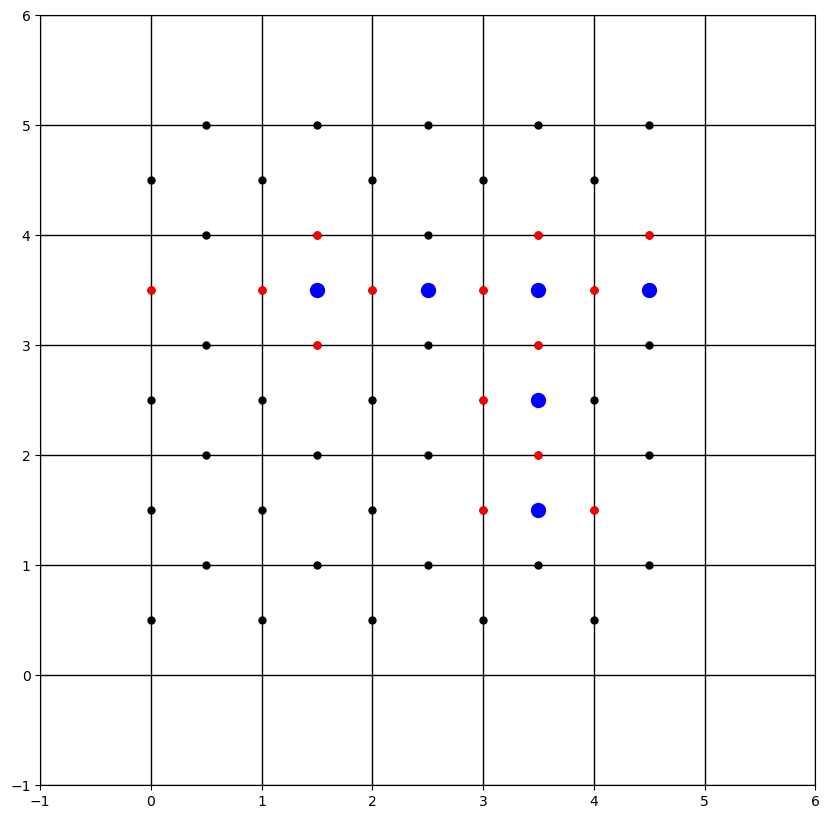

In [272]:
idx = np.random.randint(0, test_data.shape[0])
print(idx)
predr= pred.round()[idx]

pp_code(test_data[idx].reshape(5,5), predr.reshape(10,5))

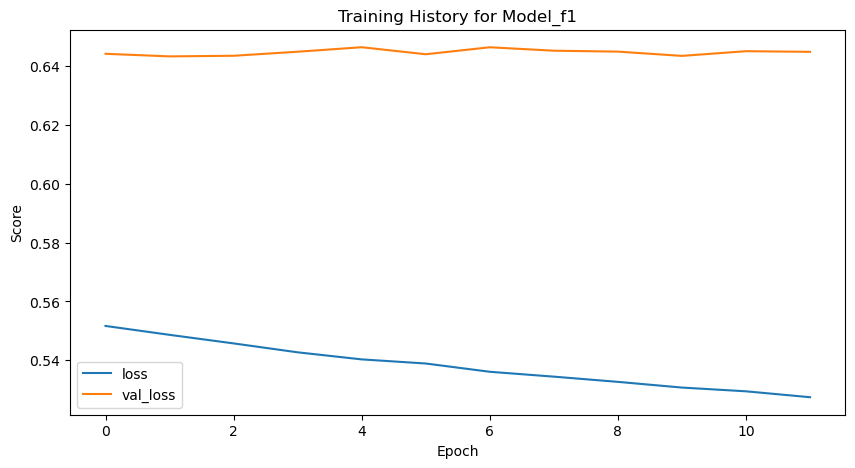

In [273]:
# plot training history for model_f1
plt.figure(figsize=(10, 5))
plt.plot(history_f1.history['loss'], '-', label='loss')
plt.plot(history_f1.history['val_loss'], '-', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training History for Model_f1')
plt.legend()
plt.show()

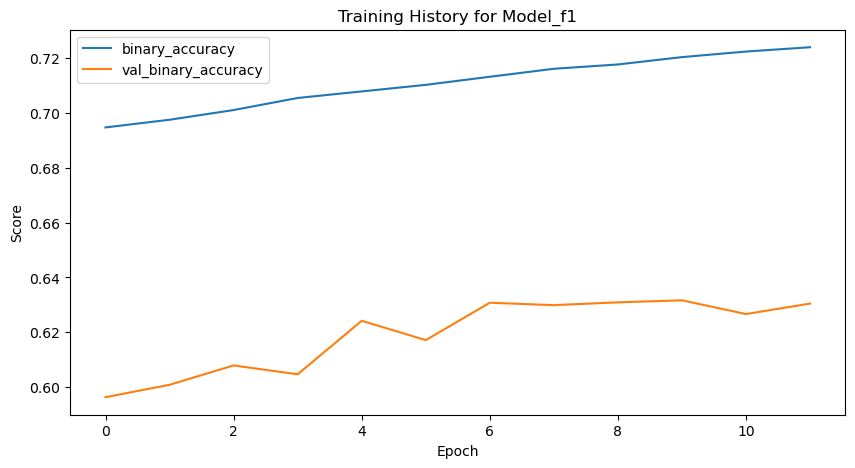

In [274]:
# plot training history for model_f1
plt.figure(figsize=(10, 5))
plt.plot(history_f1.history['binary_accuracy'], '-', label='binary_accuracy')
plt.plot(history_f1.history['val_binary_accuracy'], '-', label='val_binary_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training History for Model_f1')
plt.legend()
plt.show()


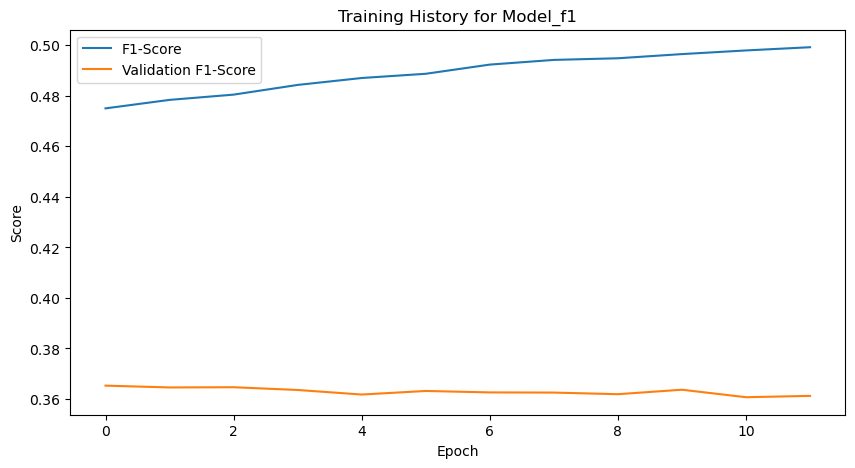

In [275]:
plt.figure(figsize=(10, 5))
plt.plot(history_f1.history['macro_f1'], '-', label='F1-Score')
plt.plot(history_f1.history['val_macro_f1'], '-', label='Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training History for Model_f1')
plt.legend()
plt.show()
